In [2]:
!pip install PIL
!pip install requests

Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import requests
from PIL import Image
import torch

In [3]:
from transformers import OwlViTProcessor, OwlViTForObjectDetection

In [7]:
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

In [20]:
# Define the local image path
image_path = r"C:\Users\pkathi\Desktop\my work\object detection\fire-pre-datasetyolov5-620\fire\train\images\65a074a2dbfed5b6.jpg"

# Open the image using PIL
image = Image.open(image_path)

# Define the texts for classification
texts = [["a photo contains fire", "a photo contains smoke"]]

# Assuming you have a processor for the model (e.g., for text inputs)
inputs = processor(text=texts, images=image, return_tensors="pt")

# Get the outputs from the model
outputs = model(**inputs)

In [21]:
# Target image sizes (height, width) to rescale box predictions [batch_size, 2]
target_sizes = torch.Tensor([image.size[::-1]])

In [22]:
# Convert outputs (bounding boxes and class logits) to Pascal VOC format (xmin, ymin, xmax, ymax)
results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.1)

In [23]:
i = 0  # Retrieve predictions for the first image for the corresponding text queries
text = texts[i]
boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]
for box, score, label in zip(boxes, scores, labels):
    box = [round(i, 2) for i in box.tolist()]
    print(f"Detected {text[label]} with confidence {round(score.item(), 3)} at location {box}")

Detected a photo contains fire with confidence 0.19 at location [276.76, 219.94, 497.1, 397.46]


In [18]:
from PIL import Image
import torch
from transformers import OwlViTProcessor, OwlViTForObjectDetection

# Initialize the processor and model
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

# Define the local image path
image_path = r"C:\Users\pkathi\Desktop\my work\object detection\fire-pre-datasetyolov5-620\fire\train\images\65a074a2dbfed5b6.jpg"

# Open the local image and verify it's loaded correctly
try:
    image = Image.open(image_path)
    print("Image loaded successfully.")
except Exception as e:
    print(f"Error loading image: {e}")

# Define the texts for classification
texts = [["a photo of a fire", "a photo of smoke", "a photo of sparkle"]]

# Prepare inputs for the model and print them to verify
try:
    inputs = processor(text=texts, images=image, return_tensors="pt")
    print("Inputs processed successfully.")
except Exception as e:
    print(f"Error processing inputs: {e}")

# Get outputs from the model and print them to verify
try:
    outputs = model(**inputs)
    print("Model outputs obtained successfully.")
except Exception as e:
    print(f"Error obtaining model outputs: {e}")

# Target image sizes (height, width) to rescale box predictions [batch_size, 2]
target_sizes = torch.Tensor([image.size[::-1]])

# Convert outputs (bounding boxes and class logits) to Pascal VOC format (xmin, ymin, xmax, ymax)
try:
    results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.1)
    print("Post-processing done successfully.")
except Exception as e:
    print(f"Error in post-processing: {e}")

# Retrieve predictions for the first image for the corresponding text queries
i = 0
text = texts[i]
boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]

# Print detected objects with their scores and locations
for box, score, label in zip(boxes, scores, labels):
    box = [round(coord, 2) for coord in box.tolist()]
    print(f"Detected {text[label]} with confidence {round(score.item(), 3)} at location {box}")

# Check if any boxes are detected
if len(boxes) == 0:
    print("No objects detected.")


Image loaded successfully.
Inputs processed successfully.
Model outputs obtained successfully.
Post-processing done successfully.
Detected a photo of a fire with confidence 0.16 at location [276.76, 219.94, 497.1, 397.46]


In [44]:
import os
import cv2
import numpy as np
from multiprocessing.pool import ThreadPool
from PIL import Image
import torch
from transformers import OwlViTProcessor, OwlViTForObjectDetection

# Initialize the processor and model for classification
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

def classify_abnormality(frame):
    # Convert the frame to PIL image
    image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    # Define specific texts for classification
    texts = [["a photo of a large fire", "a photo of small flames", "a photo of heavy smoke", "a photo of light smoke", "a photo of sparkles"]]

    # Prepare inputs for the model
    inputs = processor(text=texts, images=image, return_tensors="pt")

    # Get outputs from the model
    outputs = model(**inputs)

    # Target image sizes (height, width) to rescale box predictions [batch_size, 2]
    target_sizes = torch.Tensor([image.size[::-1]])

    # Convert outputs (bounding boxes and class logits) to Pascal VOC format (xmin, ymin, xmax, ymax)
    results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.05)  # Lower threshold for more detections

    # Retrieve predictions for the first image for the corresponding text queries
    i = 0
    text = texts[i]
    boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]

    detected_abnormalities = []
    for box, score, label in zip(boxes, scores, labels):
        if score.item() > 0.5:  # Only consider detections with high confidence
            box = [round(coord, 2) for coord in box.tolist()]
            abnormality_name = text[label]
            detected_abnormalities.append((abnormality_name, round(score.item(), 3), box))

    return detected_abnormalities

def process_frame(frame, prev_frame_gray, threshold_value, min_contour_area, original_fps, frame_number, resize_factor, output_dir):
    frame_resized = cv2.resize(frame, (0, 0), fx=resize_factor, fy=resize_factor)
    frame_gray = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2GRAY)
    frame_diff = cv2.absdiff(prev_frame_gray, frame_gray)
    _, thresh = cv2.threshold(frame_diff, threshold_value, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    detected = any(cv2.contourArea(contour) > min_contour_area for contour in contours)
    if detected:
        abnormalities = classify_abnormality(frame_resized)
        if abnormalities:
            for abnormality_name, score, box in abnormalities:
                # Create a directory for the abnormality label if it doesn't exist
                label_dir = os.path.join(output_dir, abnormality_name.replace(" ", "_"))
                os.makedirs(label_dir, exist_ok=True)
                
                # Save the image with the abnormality label and timestamp
                timestamp = frame_number / original_fps
                timestamp_str = f"{timestamp:.2f}".replace('.', '_')
                output_frame_path = os.path.join(label_dir, f"frame_{timestamp_str}.jpg")
                
                # Convert frame back to BGR for saving
                frame_bgr = cv2.cvtColor(frame_resized, cv2.COLOR_RGB2BGR)
                if not cv2.imwrite(output_frame_path, frame_bgr):
                    print(f"Failed to save image at {output_frame_path}")
                
                print(f"Detected {abnormality_name} with confidence {score} at location {box}")

    return detected, frame_gray

def motion_detection(video_path, output_dir, threshold_value=25, min_contour_area=500, resize_factor=0.5, minimal_fps=5, min_abnormality_gap_minutes=1):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error opening video file")
        return

    original_fps = cap.get(cv2.CAP_PROP_FPS)
    frame_skip_interval = int(round(original_fps / minimal_fps))

    ret, prev_frame = cap.read()
    if not ret:
        print("Error reading the first frame")
        return

    prev_frame = cv2.resize(prev_frame, (0, 0), fx=resize_factor, fy=resize_factor)
    prev_frame_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    abnormality_times = []

    frame_number = 0
    abnormality_detected = False
    abnormality_start_frame = None
    abnormality_group_id = 0
    last_abnormality_time = None

    os.makedirs(output_dir, exist_ok=True)

    pool = ThreadPool(processes=4)  # Use a thread pool with 4 threads

    while True:
        for _ in range(frame_skip_interval):
            ret = cap.grab()  # Use grab to skip frames efficiently
            if not ret:
                break
            frame_number += 1

        if not ret:
            break

        ret, frame = cap.retrieve()  # Retrieve the frame after skipping
        if not ret:
            break

        # Use thread pool to process frame
        result = pool.apply_async(process_frame, (frame, prev_frame_gray, threshold_value, min_contour_area, original_fps, frame_number, resize_factor, output_dir))
        detected, prev_frame_gray = result.get()

        if detected:
            current_abnormality_time = frame_number / original_fps

            if not abnormality_detected:
                if last_abnormality_time is None or (current_abnormality_time - last_abnormality_time) >= (min_abnormality_gap_minutes * 60):
                    abnormality_group_id += 1
                    os.makedirs(os.path.join(output_dir, f"abnormality_{abnormality_group_id}"))

                abnormality_start_frame = frame_number
                abnormality_detected = True
                abnormality_times.append(frame_number)
                last_abnormality_time = current_abnormality_time

        else:
            if abnormality_detected:
                abnormality_detected = False
                abnormality_end_frame = frame_number
                abnormality_start_seconds = abnormality_start_frame / original_fps
                abnormality_end_seconds = abnormality_end_frame / original_fps
                abnormality_duration_seconds = abnormality_end_seconds - abnormality_start_seconds

                print(f"Abnormality {abnormality_group_id} start time: {int(abnormality_start_seconds // 60)} minutes {abnormality_start_seconds % 60:.2f} seconds")
                print(f"Abnormality {abnormality_group_id} duration: {int(abnormality_duration_seconds // 60)} minutes {abnormality_duration_seconds % 60:.2f} seconds")

    cap.release()
    pool.close()
    pool.join()

    total_time_seconds = frame_number / original_fps
    print(f"Total video time: {int(total_time_seconds // 60)} minutes {total_time_seconds % 60:.2f} seconds")

    return abnormality_times

# Example usage
video_path = r"C:\Users\pkathi\Desktop\my work\computervision-video\trimmed116-118.mp4"
output_dir = 'C:/Users/pkathi/Desktop/my work/computervision-video/owlViTtrail'
abnormality_times = motion_detection(video_path, output_dir, minimal_fps=5)

if abnormality_times:
    print("Abnormality detected at frame numbers:", abnormality_times)
else:
    print("No abnormality detected in the video.")


Abnormality 1 start time: 0 minutes 57.60 seconds
Abnormality 1 duration: 0 minutes 0.80 seconds
Abnormality 1 start time: 0 minutes 58.60 seconds
Abnormality 1 duration: 0 minutes 0.20 seconds
Abnormality 1 start time: 1 minutes 3.00 seconds
Abnormality 1 duration: 0 minutes 0.20 seconds
Abnormality 1 start time: 1 minutes 3.40 seconds
Abnormality 1 duration: 0 minutes 0.20 seconds
Abnormality 1 start time: 1 minutes 17.00 seconds
Abnormality 1 duration: 0 minutes 0.20 seconds
Abnormality 1 start time: 1 minutes 17.40 seconds
Abnormality 1 duration: 0 minutes 0.20 seconds
Total video time: 1 minutes 60.00 seconds
Abnormality detected at frame numbers: [1728, 1758, 1890, 1902, 2310, 2322]


In [52]:
import os
import cv2
import numpy as np
from multiprocessing.pool import ThreadPool
from PIL import Image
import torch
from transformers import OwlViTProcessor, OwlViTForObjectDetection

# Initialize the processor and model for classification
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

def classify_abnormality(frame):
    """
    Classify the given frame for abnormalities using the OwlViT model.
    
    Args:
    frame (numpy.ndarray): The video frame to classify.
    
    Returns:
    list of tuples: Detected abnormalities with their names, confidence scores, and bounding boxes.
    """
    # Convert the frame from BGR to RGB and then to a PIL image
    image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    # Define specific texts for classification
    texts = ["a photo of a large fire", "a photo of small flames", "a photo of heavy smoke", "a photo of light smoke", "a photo of sparkles"]

    # Prepare inputs for the model
    inputs = processor(text=texts, images=image, return_tensors="pt")

    # Get outputs from the model
    outputs = model(**inputs)

    # Convert outputs to Pascal VOC format (xmin, ymin, xmax, ymax)
    target_sizes = torch.Tensor([image.size[::-1]])
    results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.05)

    # Extract results for the first image
    i = 0
    text = texts
    boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]

    detected_abnormalities = []
    for box, score, label in zip(boxes, scores, labels):
        if score.item() > 0.5:  # Only consider detections with high confidence
            box = [round(coord, 2) for coord in box.tolist()]
            abnormality_name = text[label]
            detected_abnormalities.append((abnormality_name, round(score.item(), 3), box))
            print(f"Detected abnormality: {abnormality_name} with confidence {round(score.item(), 3)} at location {box}")

    if not detected_abnormalities:
        print("No abnormalities detected in this frame.")

    return detected_abnormalities

def process_frame(frame, prev_frame_gray, threshold_value, min_contour_area, original_fps, frame_number, resize_factor, output_dir):
    """
    Process a single video frame for motion and classify abnormalities.
    
    Args:
    frame (numpy.ndarray): The video frame to process.
    prev_frame_gray (numpy.ndarray): The previous frame in grayscale.
    threshold_value (int): Threshold for binary image conversion.
    min_contour_area (int): Minimum contour area to consider as an abnormality.
    original_fps (float): Frames per second of the video.
    frame_number (int): The current frame number.
    resize_factor (float): Factor to resize the frame.
    output_dir (str): Directory where output images will be saved.
    
    Returns:
    tuple: A boolean indicating if abnormalities were detected and the current grayscale frame.
    """
    # Resize the frame
    frame_resized = cv2.resize(frame, (0, 0), fx=resize_factor, fy=resize_factor)
    frame_gray = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2GRAY)

    # Compute the difference between the current and previous frame
    frame_diff = cv2.absdiff(prev_frame_gray, frame_gray)
    _, thresh = cv2.threshold(frame_diff, threshold_value, 255, cv2.THRESH_BINARY)

    # Find contours in the thresholded image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    detected = any(cv2.contourArea(contour) > min_contour_area for contour in contours)
    if detected:
        abnormalities = classify_abnormality(frame_resized)
        if abnormalities:
            for abnormality_name, score, box in abnormalities:
                # Create a directory for the abnormality label if it doesn't exist
                label_dir = os.path.join(output_dir, abnormality_name.replace(" ", "_"))
                os.makedirs(label_dir, exist_ok=True)
                
                # Save the image with the abnormality label and timestamp
                timestamp = frame_number / original_fps
                timestamp_str = f"{timestamp:.2f}".replace('.', '_')
                output_frame_path = os.path.join(label_dir, f"frame_{timestamp_str}.jpg")
                
                # Convert frame back to BGR for saving
                frame_bgr = cv2.cvtColor(frame_resized, cv2.COLOR_RGB2BGR)
                if not cv2.imwrite(output_frame_path, frame_bgr):
                    print(f"Failed to save image at {output_frame_path}")
                else:
                    print(f"Saved abnormality image at {output_frame_path}")

    return detected, frame_gray

def motion_detection(video_path, output_dir, threshold_value=25, min_contour_area=500, resize_factor=0.5, minimal_fps=5, min_abnormality_gap_minutes=1):
    """
    Detect motion and classify abnormalities in a video.
    
    Args:
    video_path (str): Path to the input video.
    output_dir (str): Directory where output images will be saved.
    threshold_value (int): Threshold for binary image conversion.
    min_contour_area (int): Minimum contour area to consider as an abnormality.
    resize_factor (float): Factor to resize frames.
    minimal_fps (int): Minimum FPS to process video frames.
    min_abnormality_gap_minutes (int): Minimum time gap between consecutive abnormalities to be considered separate.
    
    Returns:
    list of int: Frame numbers where abnormalities were detected.
    """
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error opening video file")
        return

    original_fps = cap.get(cv2.CAP_PROP_FPS)
    frame_skip_interval = int(round(original_fps / minimal_fps))

    ret, prev_frame = cap.read()
    if not ret:
        print("Error reading the first frame")
        return

    prev_frame = cv2.resize(prev_frame, (0, 0), fx=resize_factor, fy=resize_factor)
    prev_frame_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    abnormality_times = []

    frame_number = 0
    abnormality_detected = False
    abnormality_start_frame = None
    abnormality_group_id = 0
    last_abnormality_time = None

    os.makedirs(output_dir, exist_ok=True)

    pool = ThreadPool(processes=4)  # Use a thread pool with 4 threads

    while True:
        for _ in range(frame_skip_interval):
            ret = cap.grab()  # Use grab to skip frames efficiently
            if not ret:
                break
            frame_number += 1

        if not ret:
            break

        ret, frame = cap.retrieve()  # Retrieve the frame after skipping
        if not ret:
            break

        # Use thread pool to process frame
        result = pool.apply_async(process_frame, (frame, prev_frame_gray, threshold_value, min_contour_area, original_fps, frame_number, resize_factor, output_dir))
        detected, prev_frame_gray = result.get()

        if detected:
            current_abnormality_time = frame_number / original_fps

            if not abnormality_detected:
                if last_abnormality_time is None or (current_abnormality_time - last_abnormality_time) >= (min_abnormality_gap_minutes * 60):
                    abnormality_group_id += 1
                    os.makedirs(os.path.join(output_dir, f"abnormality_{abnormality_group_id}"))

                abnormality_start_frame = frame_number
                abnormality_detected = True
                abnormality_times.append(frame_number)
                last_abnormality_time = current_abnormality_time

        else:
            if abnormality_detected:
                abnormality_detected = False
                abnormality_end_frame = frame_number
                abnormality_start_seconds = abnormality_start_frame / original_fps
                abnormality_end_seconds = abnormality_end_frame / original_fps
                abnormality_duration_seconds = abnormality_end_seconds - abnormality_start_seconds

                print(f"Abnormality {abnormality_group_id} start time: {int(abnormality_start_seconds // 60)} minutes {abnormality_start_seconds % 60:.2f} seconds")
                print(f"Abnormality {abnormality_group_id} duration: {int(abnormality_duration_seconds // 60)} minutes {abnormality_duration_seconds % 60:.2f} seconds")

    cap.release()
    pool.close()
    pool.join()

    total_time_seconds = frame_number / original_fps
    print(f"Total video time: {int(total_time_seconds // 60)} minutes {total_time_seconds % 60:.2f} seconds")

    return abnormality_times

# Example usage
video_path = r"C:\Users\pkathi\Desktop\my work\computervision-video\output48.mp4"
output_dir = 'C:/Users/pkathi/Desktop/my work/computervision-video/owlViTtrail2'
abnormality_times = motion_detection(video_path, output_dir, minimal_fps=5)

if abnormality_times:
    print("Abnormality detected at frame numbers:", abnormality_times)
else:
    print("No abnormality detected in the video.")


No abnormalities detected in this frame.
No abnormalities detected in this frame.
No abnormalities detected in this frame.
No abnormalities detected in this frame.
No abnormalities detected in this frame.
No abnormalities detected in this frame.
No abnormalities detected in this frame.
No abnormalities detected in this frame.
No abnormalities detected in this frame.
No abnormalities detected in this frame.
No abnormalities detected in this frame.
No abnormalities detected in this frame.
No abnormalities detected in this frame.
No abnormalities detected in this frame.
No abnormalities detected in this frame.
No abnormalities detected in this frame.
No abnormalities detected in this frame.
No abnormalities detected in this frame.
No abnormalities detected in this frame.
No abnormalities detected in this frame.
No abnormalities detected in this frame.
No abnormalities detected in this frame.
No abnormalities detected in this frame.
No abnormalities detected in this frame.
No abnormalities

In [48]:
import os
import cv2
import numpy as np
from multiprocessing.pool import ThreadPool
from PIL import Image
import torch
from transformers import OwlViTProcessor, OwlViTForObjectDetection

# Initialize the processor and model for classification
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

def classify_abnormality(frame):
    # Convert the frame to PIL image
    image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    # Define specific texts for classification
    texts = [["a photo of a large fire", "a photo of small flames", "a photo of heavy smoke", "a photo of light smoke", "a photo of sparkles"]]

    # Prepare inputs for the model
    inputs = processor(text=texts, images=image, return_tensors="pt")

    # Get outputs from the model
    outputs = model(**inputs)

    # Target image sizes (height, width) to rescale box predictions [batch_size, 2]
    target_sizes = torch.Tensor([image.size[::-1]])

    # Convert outputs (bounding boxes and class logits) to Pascal VOC format (xmin, ymin, xmax, ymax)
    results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.05)

    # Retrieve predictions for the first image for the corresponding text queries
    i = 0
    text = texts[i]
    boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]

    detected_abnormalities = []
    for box, score, label in zip(boxes, scores, labels):
        if score.item() > 0.5:  # Only consider detections with high confidence
            box = [round(coord, 2) for coord in box.tolist()]
            abnormality_name = text[label]
            detected_abnormalities.append((abnormality_name, round(score.item(), 3), box))
            print(f"Detected abnormality: {abnormality_name} with confidence {round(score.item(), 3)} at location {box}")

    if not detected_abnormalities:
        print("No abnormalities detected in this frame.")

    return detected_abnormalities

def process_frame(frame, prev_frame_gray, threshold_value, min_contour_area, original_fps, frame_number, resize_factor, output_dir):
    frame_resized = cv2.resize(frame, (0, 0), fx=resize_factor, fy=resize_factor)
    frame_gray = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2GRAY)
    frame_diff = cv2.absdiff(prev_frame_gray, frame_gray)
    _, thresh = cv2.threshold(frame_diff, threshold_value, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    detected = any(cv2.contourArea(contour) > min_contour_area for contour in contours)
    if detected:
        abnormalities = classify_abnormality(frame_resized)
        if abnormalities:
            for abnormality_name, score, box in abnormalities:
                # Create a directory for the abnormality label if it doesn't exist
                label_dir = os.path.join(output_dir, abnormality_name.replace(" ", "_"))
                os.makedirs(label_dir, exist_ok=True)
                
                # Save the image with the abnormality label and timestamp
                timestamp = frame_number / original_fps
                timestamp_str = f"{timestamp:.2f}".replace('.', '_')
                output_frame_path = os.path.join(label_dir, f"frame_{timestamp_str}.jpg")
                
                # Convert frame back to BGR for saving
                frame_bgr = cv2.cvtColor(frame_resized, cv2.COLOR_RGB2BGR)
                if not cv2.imwrite(output_frame_path, frame_bgr):
                    print(f"Failed to save image at {output_frame_path}")
                else:
                    print(f"Saved abnormality image at {output_frame_path}")

    return detected, frame_gray

def motion_detection(video_path, output_dir, threshold_value=25, min_contour_area=500, resize_factor=0.5, minimal_fps=5, min_abnormality_gap_minutes=1):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error opening video file")
        return

    original_fps = cap.get(cv2.CAP_PROP_FPS)
    frame_skip_interval = int(round(original_fps / minimal_fps))

    ret, prev_frame = cap.read()
    if not ret:
        print("Error reading the first frame")
        return

    prev_frame = cv2.resize(prev_frame, (0, 0), fx=resize_factor, fy=resize_factor)
    prev_frame_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    abnormality_times = []

    frame_number = 0
    abnormality_detected = False
    abnormality_start_frame = None
    abnormality_group_id = 0
    last_abnormality_time = None

    os.makedirs(output_dir, exist_ok=True)

    pool = ThreadPool(processes=4)  # Use a thread pool with 4 threads

    while True:
        for _ in range(frame_skip_interval):
            ret = cap.grab()  # Use grab to skip frames efficiently
            if not ret:
                break
            frame_number += 1

        if not ret:
            break

        ret, frame = cap.retrieve()  # Retrieve the frame after skipping
        if not ret:
            break

        # Use thread pool to process frame
        result = pool.apply_async(process_frame, (frame, prev_frame_gray, threshold_value, min_contour_area, original_fps, frame_number, resize_factor, output_dir))
        detected, prev_frame_gray = result.get()

        if detected:
            current_abnormality_time = frame_number / original_fps

            if not abnormality_detected:
                if last_abnormality_time is None or (current_abnormality_time - last_abnormality_time) >= (min_abnormality_gap_minutes * 60):
                    abnormality_group_id += 1
                    os.makedirs(os.path.join(output_dir, f"abnormality_{abnormality_group_id}"))

                abnormality_start_frame = frame_number
                abnormality_detected = True
                abnormality_times.append(frame_number)
                last_abnormality_time = current_abnormality_time

        else:
            if abnormality_detected:
                abnormality_detected = False
                abnormality_end_frame = frame_number
                abnormality_start_seconds = abnormality_start_frame / original_fps
                abnormality_end_seconds = abnormality_end_frame / original_fps
                abnormality_duration_seconds = abnormality_end_seconds - abnormality_start_seconds

                print(f"Abnormality {abnormality_group_id} start time: {int(abnormality_start_seconds // 60)} minutes {abnormality_start_seconds % 60:.2f} seconds")
                print(f"Abnormality {abnormality_group_id} duration: {int(abnormality_duration_seconds // 60)} minutes {abnormality_duration_seconds % 60:.2f} seconds")

    cap.release()
    pool.close()
    pool.join()

    total_time_seconds = frame_number / original_fps
    print(f"Total video time: {int(total_time_seconds // 60)} minutes {total_time_seconds % 60:.2f} seconds")

    return abnormality_times

# Example usage
video_path = r"C:\Users\pkathi\Desktop\my work\computervision-video\116-118.mp4"
output_dir = 'C:/Users/pkathi/Desktop/my work/computervision-video/owlViTtrail2'
abnormality_times = motion_detection(video_path, output_dir, minimal_fps=5)

if abnormality_times:
    print("Abnormality detected at frame numbers:", abnormality_times)
else:
    print("No abnormality detected in the video.")


No abnormalities detected in this frame.
No abnormalities detected in this frame.
No abnormalities detected in this frame.
No abnormalities detected in this frame.
Abnormality 1 start time: 0 minutes 57.60 seconds
Abnormality 1 duration: 0 minutes 0.80 seconds
No abnormalities detected in this frame.
Abnormality 1 start time: 0 minutes 58.60 seconds
Abnormality 1 duration: 0 minutes 0.20 seconds
No abnormalities detected in this frame.
Abnormality 1 start time: 1 minutes 3.00 seconds
Abnormality 1 duration: 0 minutes 0.20 seconds
No abnormalities detected in this frame.
Abnormality 1 start time: 1 minutes 3.40 seconds
Abnormality 1 duration: 0 minutes 0.20 seconds
No abnormalities detected in this frame.
Abnormality 1 start time: 1 minutes 17.00 seconds
Abnormality 1 duration: 0 minutes 0.20 seconds
No abnormalities detected in this frame.
Abnormality 1 start time: 1 minutes 17.40 seconds
Abnormality 1 duration: 0 minutes 0.20 seconds
Total video time: 1 minutes 60.00 seconds
Abnormali

In [54]:
import cv2
import numpy as np
import os
from multiprocessing.pool import ThreadPool
from PIL import Image
import torch
from transformers import OwlViTProcessor, OwlViTForObjectDetection
import matplotlib.pyplot as plt

# Initialize the processor and model
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

def classify_abnormality(frame_path, texts):
    image = Image.open(frame_path)
    inputs = processor(text=texts, images=image, return_tensors="pt")
    outputs = model(**inputs)
    target_sizes = torch.Tensor([image.size[::-1]])
    results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.05)
    return results

def process_frame(frame, prev_frame_gray, threshold_value, min_contour_area, original_fps, frame_number, resize_factor, output_dir, abnormality_group_id):
    frame_resized = cv2.resize(frame, (0, 0), fx=resize_factor, fy=resize_factor)
    frame_gray = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2GRAY)
    frame_diff = cv2.absdiff(prev_frame_gray, frame_gray)
    _, thresh = cv2.threshold(frame_diff, threshold_value, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    detected = any(cv2.contourArea(contour) > min_contour_area for contour in contours)
    if detected:
        output_frame_path = os.path.join(output_dir, f"abnormality_{abnormality_group_id}", f"frame_{frame_number}.jpg")
        cv2.imwrite(output_frame_path, frame_resized)
    
    return detected, frame_gray

def motion_detection(video_path, output_dir, threshold_value=25, min_contour_area=500, resize_factor=0.5, minimal_fps=5, min_abnormality_gap_minutes=1):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error opening video file")
        return

    original_fps = cap.get(cv2.CAP_PROP_FPS)
    frame_skip_interval = int(round(original_fps / minimal_fps))

    ret, prev_frame = cap.read()
    if not ret:
        print("Error reading the first frame")
        return

    prev_frame = cv2.resize(prev_frame, (0, 0), fx=resize_factor, fy=resize_factor)
    prev_frame_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    abnormality_times = []

    frame_number = 0
    abnormality_detected = False
    abnormality_start_frame = None
    abnormality_group_id = 0
    last_abnormality_time = None

    os.makedirs(output_dir, exist_ok=True)

    pool = ThreadPool(processes=4)  # Use a thread pool with 4 threads

    while True:
        for _ in range(frame_skip_interval):
            ret = cap.grab()  # Use grab to skip frames efficiently
            if not ret:
                break
            frame_number += 1

        if not ret:
            break

        ret, frame = cap.retrieve()  # Retrieve the frame after skipping
        if not ret:
            break

        # Use thread pool to process frame
        result = pool.apply_async(process_frame, (frame, prev_frame_gray, threshold_value, min_contour_area, original_fps, frame_number, resize_factor, output_dir, abnormality_group_id))
        detected, prev_frame_gray = result.get()

        if detected:
            current_abnormality_time = frame_number / original_fps

            if not abnormality_detected:
                if last_abnormality_time is None or (current_abnormality_time - last_abnormality_time) >= (min_abnormality_gap_minutes * 60):
                    abnormality_group_id += 1
                    os.makedirs(os.path.join(output_dir, f"abnormality_{abnormality_group_id}"))

                abnormality_start_frame = frame_number
                abnormality_detected = True
                abnormality_times.append(frame_number)
                last_abnormality_time = current_abnormality_time

        else:
            if abnormality_detected:
                abnormality_detected = False
                abnormality_end_frame = frame_number
                abnormality_start_seconds = abnormality_start_frame / original_fps
                abnormality_end_seconds = abnormality_end_frame / original_fps
                abnormality_duration_seconds = abnormality_end_seconds - abnormality_start_seconds

                print(f"Abnormality {abnormality_group_id} start time: {int(abnormality_start_seconds // 60)} minutes {abnormality_start_seconds % 60:.2f} seconds")
                print(f"Abnormality {abnormality_group_id} duration: {int(abnormality_duration_seconds // 60)} minutes {abnormality_duration_seconds % 60:.2f} seconds")

    cap.release()
    pool.close()
    pool.join()

    total_time_seconds = frame_number / original_fps
    print(f"Total video time: {int(total_time_seconds // 60)} minutes {total_time_seconds % 60:.2f} seconds")

    return abnormality_times

def classify_and_save_abnormalities(output_dir, texts):
    for abnormality_folder in os.listdir(output_dir):
        folder_path = os.path.join(output_dir, abnormality_folder)
        if os.path.isdir(folder_path):
            for image_file in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_file)
                results = classify_abnormality(image_path, texts)
                
                if not results[0]["boxes"].numel():
                    dest_dir = os.path.join(output_dir, 'unknown')
                else:
                    labels = [texts[0][label] for label in results[0]["labels"]]
                    label_set = set(labels)
                    if "a photo of a large fire" in label_set or "a photo of small flames" in label_set:
                        if "a photo of heavy smoke" in label_set or "a photo of light smoke" in label_set:
                            dest_dir = os.path.join(output_dir, 'fire+smoke')
                        else:
                            dest_dir = os.path.join(output_dir, 'fire')
                    elif "a photo of heavy smoke" in label_set or "a photo of light smoke" in label_set:
                        dest_dir = os.path.join(output_dir, 'smoke')
                    elif "a photo of sparkles" in label_set:
                        dest_dir = os.path.join(output_dir, 'sparkles')
                    else:
                        dest_dir = os.path.join(output_dir, 'unknown')
                
                os.makedirs(dest_dir, exist_ok=True)
                dest_path = os.path.join(dest_dir, image_file)
                os.rename(image_path, dest_path)

# Example usage
video_path = r"C:\Users\pkathi\Desktop\my work\computervision-video\output48.mp4"
output_dir = 'C:/Users/pkathi/Desktop/my work/computervision-video/trailVIT'
abnormality_times = motion_detection(video_path, output_dir, minimal_fps=5)

if abnormality_times:
    print("Abnormality detected at frame numbers:", abnormality_times)
    texts = [["a photo of a large fire", "a photo of small flames", "a photo of heavy smoke", "a photo of light smoke", "a photo of sparkles"]]
    classify_and_save_abnormalities(output_dir, texts)
else:
    print("No abnormality detected in the video.")


Abnormality 1 start time: 0 minutes 45.00 seconds
Abnormality 1 duration: 0 minutes 12.00 seconds
Abnormality 1 start time: 0 minutes 57.40 seconds
Abnormality 1 duration: 0 minutes 0.20 seconds
Abnormality 1 start time: 0 minutes 57.80 seconds
Abnormality 1 duration: 0 minutes 0.20 seconds
Abnormality 1 start time: 0 minutes 58.20 seconds
Abnormality 1 duration: 0 minutes 0.20 seconds
Total video time: 0 minutes 60.00 seconds
Abnormality detected at frame numbers: [1350, 1722, 1734, 1746, 1758]


In [55]:
import cv2
import numpy as np
import os
from multiprocessing.pool import ThreadPool
from PIL import Image
import torch
from transformers import OwlViTProcessor, OwlViTForObjectDetection
import matplotlib.pyplot as plt

# Initialize the processor and model
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

def classify_abnormality(frame_path, texts):
    image = Image.open(frame_path)
    inputs = processor(text=texts, images=image, return_tensors="pt")
    outputs = model(**inputs)
    target_sizes = torch.Tensor([image.size[::-1]])
    results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.05)
    return results

def process_frame(frame, prev_frame_gray, threshold_value, min_contour_area, original_fps, frame_number, resize_factor, output_dir, abnormality_group_id):
    frame_resized = cv2.resize(frame, (0, 0), fx=resize_factor, fy=resize_factor)
    frame_gray = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2GRAY)
    frame_diff = cv2.absdiff(prev_frame_gray, frame_gray)
    _, thresh = cv2.threshold(frame_diff, threshold_value, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    detected = any(cv2.contourArea(contour) > min_contour_area for contour in contours)
    if detected:
        output_frame_path = os.path.join(output_dir, f"abnormality_{abnormality_group_id}", f"frame_{frame_number}.jpg")
        cv2.imwrite(output_frame_path, frame_resized)
    
    return detected, frame_gray

def motion_detection(video_path, output_dir, threshold_value=25, min_contour_area=500, resize_factor=0.5, minimal_fps=5, min_abnormality_gap_minutes=1):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error opening video file")
        return

    original_fps = cap.get(cv2.CAP_PROP_FPS)
    frame_skip_interval = int(round(original_fps / minimal_fps))

    ret, prev_frame = cap.read()
    if not ret:
        print("Error reading the first frame")
        return

    prev_frame = cv2.resize(prev_frame, (0, 0), fx=resize_factor, fy=resize_factor)
    prev_frame_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    abnormality_times = []

    frame_number = 0
    abnormality_detected = False
    abnormality_start_frame = None
    abnormality_group_id = 0
    last_abnormality_time = None

    os.makedirs(output_dir, exist_ok=True)

    pool = ThreadPool(processes=4)  # Use a thread pool with 4 threads

    while True:
        for _ in range(frame_skip_interval):
            ret = cap.grab()  # Use grab to skip frames efficiently
            if not ret:
                break
            frame_number += 1

        if not ret:
            break

        ret, frame = cap.retrieve()  # Retrieve the frame after skipping
        if not ret:
            break

        # Use thread pool to process frame
        result = pool.apply_async(process_frame, (frame, prev_frame_gray, threshold_value, min_contour_area, original_fps, frame_number, resize_factor, output_dir, abnormality_group_id))
        detected, prev_frame_gray = result.get()

        if detected:
            current_abnormality_time = frame_number / original_fps

            if not abnormality_detected:
                if last_abnormality_time is None or (current_abnormality_time - last_abnormality_time) >= (min_abnormality_gap_minutes * 60):
                    abnormality_group_id += 1
                    os.makedirs(os.path.join(output_dir, f"abnormality_{abnormality_group_id}"))

                abnormality_start_frame = frame_number
                abnormality_detected = True
                abnormality_times.append(frame_number)
                last_abnormality_time = current_abnormality_time

        else:
            if abnormality_detected:
                abnormality_detected = False
                abnormality_end_frame = frame_number
                abnormality_start_seconds = abnormality_start_frame / original_fps
                abnormality_end_seconds = abnormality_end_frame / original_fps
                abnormality_duration_seconds = abnormality_end_seconds - abnormality_start_seconds

                print(f"Abnormality {abnormality_group_id} start time: {int(abnormality_start_seconds // 60)} minutes {abnormality_start_seconds % 60:.2f} seconds")
                print(f"Abnormality {abnormality_group_id} duration: {int(abnormality_duration_seconds // 60)} minutes {abnormality_duration_seconds % 60:.2f} seconds")

    cap.release()
    pool.close()
    pool.join()

    total_time_seconds = frame_number / original_fps
    print(f"Total video time: {int(total_time_seconds // 60)} minutes {total_time_seconds % 60:.2f} seconds")

    return abnormality_times

def classify_and_save_abnormalities(output_dir, texts):
    for abnormality_folder in os.listdir(output_dir):
        folder_path = os.path.join(output_dir, abnormality_folder)
        if os.path.isdir(folder_path):
            for image_file in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_file)
                results = classify_abnormality(image_path, texts)
                
                if not results[0]["boxes"].numel():
                    dest_dir = os.path.join(output_dir, 'unknown')
                else:
                    labels = [texts[0][label] for label in results[0]["labels"]]
                    label_set = set(labels)
                    if "a photo of a large fire" in label_set or "a photo of small flames" in label_set:
                        if "a photo of heavy smoke" in label_set or "a photo of light smoke" in label_set:
                            dest_dir = os.path.join(output_dir, 'fire+smoke')
                        else:
                            dest_dir = os.path.join(output_dir, 'fire')
                    elif "a photo of heavy smoke" in label_set or "a photo of light smoke" in label_set:
                        dest_dir = os.path.join(output_dir, 'smoke')
                    elif "a photo of sparkles" in label_set:
                        dest_dir = os.path.join(output_dir, 'sparkles')
                    else:
                        dest_dir = os.path.join(output_dir, 'unknown')
                
                os.makedirs(dest_dir, exist_ok=True)
                dest_path = os.path.join(dest_dir, image_file)
                os.rename(image_path, dest_path)

# Example usage
video_path = r"C:\Users\pkathi\Desktop\my work\computervision-video\trimmed116-118.mp4"
output_dir = 'C:/Users/pkathi/Desktop/my work/computervision-video/OWLtrailVIT'
abnormality_times = motion_detection(video_path, output_dir, minimal_fps=5)

if abnormality_times:
    print("Abnormality detected at frame numbers:", abnormality_times)
    texts = [["a photo of fire", "a photo of heavy smoke", "a photo of smoke", "a photo of both fire and smoke"]]
    classify_and_save_abnormalities(output_dir, texts)
else:
    print("No abnormality detected in the video.")


Abnormality 1 start time: 0 minutes 57.60 seconds
Abnormality 1 duration: 0 minutes 0.80 seconds
Abnormality 1 start time: 0 minutes 58.60 seconds
Abnormality 1 duration: 0 minutes 0.20 seconds
Abnormality 1 start time: 1 minutes 3.00 seconds
Abnormality 1 duration: 0 minutes 0.20 seconds
Abnormality 1 start time: 1 minutes 3.40 seconds
Abnormality 1 duration: 0 minutes 0.20 seconds
Abnormality 1 start time: 1 minutes 17.00 seconds
Abnormality 1 duration: 0 minutes 0.20 seconds
Abnormality 1 start time: 1 minutes 17.40 seconds
Abnormality 1 duration: 0 minutes 0.20 seconds
Total video time: 1 minutes 60.00 seconds
Abnormality detected at frame numbers: [1728, 1758, 1890, 1902, 2310, 2322]


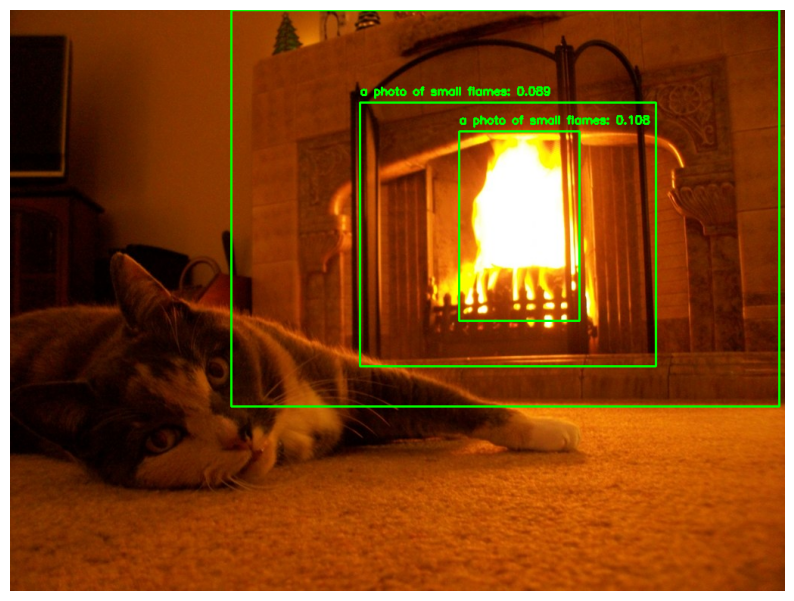

Detected a photo of a large fire with confidence 0.056 at location [292.58, 1.25, 1016.8, 524.41]
Detected a photo of small flames with confidence 0.089 at location [462.13, 123.09, 853.5, 471.53]
Detected a photo of small flames with confidence 0.108 at location [593.9, 161.33, 752.23, 411.71]


In [13]:
from PIL import Image
import torch
import cv2
import numpy as np
from transformers import OwlViTProcessor, OwlViTForObjectDetection
import matplotlib.pyplot as plt

# Initialize the processor and model
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

# Define the local image path
image_path = r"C:\Users\pkathi\Desktop\my work\object detection\fire-pre-datasetyolov5-620\fire\train\images\062fe9763653de32.jpg"

# Open the local image
image = Image.open(image_path)

# Define more specific texts for classification
texts = [["a photo of a large fire", "a photo of small flames", "a photo of heavy smoke", "a photo of light smoke", "a photo of sparkles"]]

# Prepare inputs for the model
inputs = processor(text=texts, images=image, return_tensors="pt")

# Get outputs from the model
outputs = model(**inputs)

# Target image sizes (height, width) to rescale box predictions [batch_size, 2]
target_sizes = torch.Tensor([image.size[::-1]])

# Convert outputs (bounding boxes and class logits) to Pascal VOC format (xmin, ymin, xmax, ymax)
results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.05)  # Lower threshold for more detections

# Retrieve predictions for the first image for the corresponding text queries
i = 0
text = texts[i]
boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]

# Convert the PIL image to a numpy array
image_np = np.array(image)

# Convert RGB to BGR for OpenCV
image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

# Draw the bounding boxes and labels on the image
for box, score, label in zip(boxes, scores, labels):
    box = [round(coord, 2) for coord in box.tolist()]
    x1, y1, x2, y2 = map(int, box)
    cv2.rectangle(image_np, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(image_np, f"{text[label]}: {round(score.item(), 3)}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Convert BGR to RGB for displaying with matplotlib
image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(image_np)
plt.axis('off')
plt.show()

# Check if any boxes are detected
if boxes.numel() == 0:
    print("No objects detected.")
else:
    for box, score, label in zip(boxes, scores, labels):
        box = [round(coord, 2) for coord in box.tolist()]
        print(f"Detected {text[label]} with confidence {round(score.item(), 3)} at location {box}")


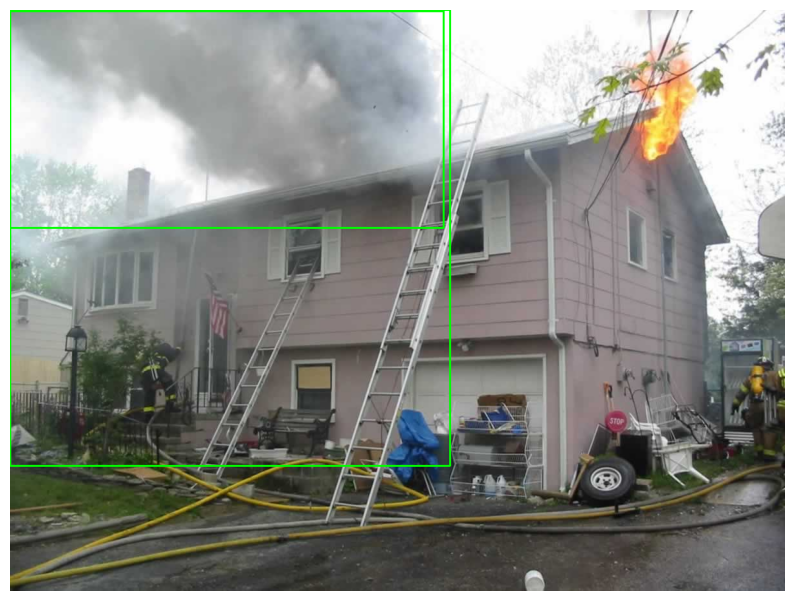

Detected a photo of smoke with confidence 0.147 at location [-1.49, 3.82, 671.86, 338.5]
Detected a photo of smoke with confidence 0.066 at location [0.05, 1.03, 681.81, 706.51]


In [14]:
from PIL import Image
import torch
import cv2
import numpy as np
from transformers import OwlViTProcessor, OwlViTForObjectDetection
import matplotlib.pyplot as plt

# Initialize the processor and model
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

# Define the local image path
image_path = r"C:\Users\pkathi\Desktop\my work\object detection\fire-pre-datasetyolov5-620\fire\train\images\61 - Copy.jpg"

# Open the local image
image = Image.open(image_path)

# Define more specific texts for classification
texts = [["a photo of fire", "a photo of smoke", "a photo of fire and smoke"]]

# Prepare inputs for the model
inputs = processor(text=texts, images=image, return_tensors="pt")

# Get outputs from the model
outputs = model(**inputs)

# Target image sizes (height, width) to rescale box predictions [batch_size, 2]
target_sizes = torch.Tensor([image.size[::-1]])

# Convert outputs (bounding boxes and class logits) to Pascal VOC format (xmin, ymin, xmax, ymax)
results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.05)  # Lower threshold for more detections

# Retrieve predictions for the first image for the corresponding text queries
i = 0
text = texts[i]
boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]

# Convert the PIL image to a numpy array
image_np = np.array(image)

# Convert RGB to BGR for OpenCV
image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

# Draw the bounding boxes and labels on the image
for box, score, label in zip(boxes, scores, labels):
    box = [round(coord, 2) for coord in box.tolist()]
    x1, y1, x2, y2 = map(int, box)
    cv2.rectangle(image_np, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(image_np, f"{text[label]}: {round(score.item(), 3)}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Convert BGR to RGB for displaying with matplotlib
image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(image_np)
plt.axis('off')
plt.show()

# Check if any boxes are detected
if boxes.numel() == 0:
    print("No objects detected.")
else:
    for box, score, label in zip(boxes, scores, labels):
        box = [round(coord, 2) for coord in box.tolist()]
        print(f"Detected {text[label]} with confidence {round(score.item(), 3)} at location {box}")


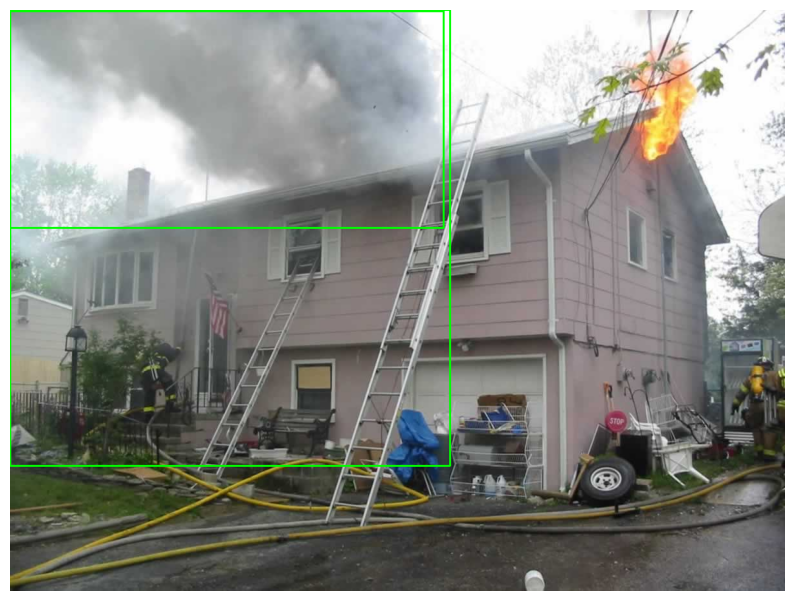

Detected a photo of light smoke with confidence 0.146 at location [-1.49, 3.82, 671.86, 338.5]
Detected a photo of light smoke with confidence 0.079 at location [0.05, 1.03, 681.81, 706.51]


In [15]:
from PIL import Image
import torch
import cv2
import numpy as np
from transformers import OwlViTProcessor, OwlViTForObjectDetection
import matplotlib.pyplot as plt

# Initialize the processor and model
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

# Define the local image path
image_path = r"C:\Users\pkathi\Desktop\my work\object detection\fire-pre-datasetyolov5-620\fire\train\images\61 - Copy.jpg"

# Open the local image
image = Image.open(image_path)

# Define more specific texts for classification
texts = [["a photo of a large fire", "a photo of small flames", "a photo of heavy smoke", "a photo of light smoke", "a photo of sparkles"]]

# Prepare inputs for the model
inputs = processor(text=texts, images=image, return_tensors="pt")

# Get outputs from the model
outputs = model(**inputs)

# Target image sizes (height, width) to rescale box predictions [batch_size, 2]
target_sizes = torch.Tensor([image.size[::-1]])

# Convert outputs (bounding boxes and class logits) to Pascal VOC format (xmin, ymin, xmax, ymax)
results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.05)  # Lower threshold for more detections

# Retrieve predictions for the first image for the corresponding text queries
i = 0
text = texts[i]
boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]

# Convert the PIL image to a numpy array
image_np = np.array(image)

# Convert RGB to BGR for OpenCV
image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

# Draw the bounding boxes and labels on the image
for box, score, label in zip(boxes, scores, labels):
    box = [round(coord, 2) for coord in box.tolist()]
    x1, y1, x2, y2 = map(int, box)
    cv2.rectangle(image_np, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(image_np, f"{text[label]}: {round(score.item(), 3)}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Convert BGR to RGB for displaying with matplotlib
image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(image_np)
plt.axis('off')
plt.show()

# Check if any boxes are detected
if boxes.numel() == 0:
    print("No objects detected.")
else:
    for box, score, label in zip(boxes, scores, labels):
        box = [round(coord, 2) for coord in box.tolist()]
        print(f"Detected {text[label]} with confidence {round(score.item(), 3)} at location {box}")


In [16]:
from PIL import Image
import torch
from transformers import OwlViTProcessor, OwlViTForObjectDetection

# Initialize the processor and model
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

# Define the local image path
image_path = r"C:\Users\pkathi\Desktop\my work\object detection\fire-pre-datasetyolov5-620\fire\train\images\61 - Copy.jpg"

# Open the local image
image = Image.open(image_path)

# Define more specific texts for classification
texts = [["a photo of a large fire", "a photo of small flames", "a photo of heavy smoke", "a photo of light smoke", "a photo of sparkles"]]

# Prepare inputs for the model
inputs = processor(text=texts, images=image, return_tensors="pt")

# Get outputs from the model
outputs = model(**inputs)

# Target image sizes (height, width) to rescale box predictions [batch_size, 2]
target_sizes = torch.Tensor([image.size[::-1]])

# Convert outputs (bounding boxes and class logits) to Pascal VOC format (xmin, ymin, xmax, ymax)
results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.05)  # Lower threshold for more detections

# Retrieve predictions for the first image for the corresponding text queries
i = 0
text = texts[i]
boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]

# Print detected objects with their scores and locations
detected = False
for box, score, label in zip(boxes, scores, labels):
    box = [round(coord, 2) for coord in box.tolist()]
    print(f"Detected {text[label]} with confidence {round(score.item(), 3)} at location {box}")
    detected = True

# Check if any boxes are detected
if not detected:
    print("No objects detected.")

Detected a photo of light smoke with confidence 0.146 at location [-1.49, 3.82, 671.86, 338.5]
Detected a photo of light smoke with confidence 0.079 at location [0.05, 1.03, 681.81, 706.51]


In [17]:
from PIL import Image
import torch
from transformers import OwlViTProcessor, OwlViTForObjectDetection

# Initialize the processor and model
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

# Define the local image path
image_path = r"C:\Users\pkathi\Desktop\my work\object detection\fire-pre-datasetyolov5-620\fire\train\images\65a074a2dbfed5b6.jpg"

# Open the local image
image = Image.open(image_path)

# Define more specific texts for classification
texts = [["a photo of a large fire", "a photo of small flames", "a photo of heavy smoke", "a photo of light smoke", "a photo of sparkles"]]

# Prepare inputs for the model
inputs = processor(text=texts, images=image, return_tensors="pt")

# Get outputs from the model
outputs = model(**inputs)

# Target image sizes (height, width) to rescale box predictions [batch_size, 2]
target_sizes = torch.Tensor([image.size[::-1]])

# Convert outputs (bounding boxes and class logits) to Pascal VOC format (xmin, ymin, xmax, ymax)
results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.05)  # Lower threshold for more detections

# Retrieve predictions for the first image for the corresponding text queries
i = 0
text = texts[i]
boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]

# Print detected objects with their scores and locations
detected = False
for box, score, label in zip(boxes, scores, labels):
    box = [round(coord, 2) for coord in box.tolist()]
    print(f"Detected {text[label]} with confidence {round(score.item(), 3)} at location {box}")
    detected = True

# Check if any boxes are detected
if not detected:
    print("No objects detected.")

Detected a photo of a large fire with confidence 0.075 at location [225.52, 179.95, 532.65, 409.42]
Detected a photo of a large fire with confidence 0.073 at location [259.14, 210.3, 502.17, 399.91]
Detected a photo of a large fire with confidence 0.073 at location [288.16, 228.3, 486.64, 394.7]
Detected a photo of small flames with confidence 0.075 at location [289.64, 293.25, 431.68, 390.95]
Detected a photo of a large fire with confidence 0.149 at location [276.76, 219.94, 497.1, 397.46]


In [56]:
import cv2
import numpy as np
import os
from multiprocessing.pool import ThreadPool
from PIL import Image
import torch
from transformers import OwlViTProcessor, OwlViTForObjectDetection
import matplotlib.pyplot as plt

# Initialize the processor and model
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

def classify_abnormality(frame_path, texts):
    image = Image.open(frame_path)
    inputs = processor(text=texts, images=image, return_tensors="pt")
    outputs = model(**inputs)
    target_sizes = torch.Tensor([image.size[::-1]])
    results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.05)
    return results

def process_frame(frame, prev_frame_gray, threshold_value, min_contour_area, original_fps, frame_number, resize_factor, output_dir, abnormality_group_id):
    frame_resized = cv2.resize(frame, (0, 0), fx=resize_factor, fy=resize_factor)
    frame_gray = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2GRAY)
    frame_diff = cv2.absdiff(prev_frame_gray, frame_gray)
    _, thresh = cv2.threshold(frame_diff, threshold_value, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    detected = any(cv2.contourArea(contour) > min_contour_area for contour in contours)
    if detected:
        output_frame_path = os.path.join(output_dir, f"abnormality_{abnormality_group_id}", f"frame_{frame_number}.jpg")
        cv2.imwrite(output_frame_path, frame_resized)
    
    return detected, frame_gray

def motion_detection(video_path, output_dir, threshold_value=25, min_contour_area=500, resize_factor=0.5, minimal_fps=5, min_abnormality_gap_minutes=1):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error opening video file")
        return

    original_fps = cap.get(cv2.CAP_PROP_FPS)
    frame_skip_interval = int(round(original_fps / minimal_fps))

    ret, prev_frame = cap.read()
    if not ret:
        print("Error reading the first frame")
        return

    prev_frame = cv2.resize(prev_frame, (0, 0), fx=resize_factor, fy=resize_factor)
    prev_frame_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    abnormality_times = []

    frame_number = 0
    abnormality_detected = False
    abnormality_start_frame = None
    abnormality_group_id = 0
    last_abnormality_time = None

    os.makedirs(output_dir, exist_ok=True)

    pool = ThreadPool(processes=4)  # Use a thread pool with 4 threads

    while True:
        for _ in range(frame_skip_interval):
            ret = cap.grab()  # Use grab to skip frames efficiently
            if not ret:
                break
            frame_number += 1

        if not ret:
            break

        ret, frame = cap.retrieve()  # Retrieve the frame after skipping
        if not ret:
            break

        # Use thread pool to process frame
        result = pool.apply_async(process_frame, (frame, prev_frame_gray, threshold_value, min_contour_area, original_fps, frame_number, resize_factor, output_dir, abnormality_group_id))
        detected, prev_frame_gray = result.get()

        if detected:
            current_abnormality_time = frame_number / original_fps

            if not abnormality_detected:
                if last_abnormality_time is None or (current_abnormality_time - last_abnormality_time) >= (min_abnormality_gap_minutes * 60):
                    abnormality_group_id += 1
                    os.makedirs(os.path.join(output_dir, f"abnormality_{abnormality_group_id}"))

                abnormality_start_frame = frame_number
                abnormality_detected = True
                abnormality_times.append(frame_number)
                last_abnormality_time = current_abnormality_time

        else:
            if abnormality_detected:
                abnormality_detected = False
                abnormality_end_frame = frame_number
                abnormality_start_seconds = abnormality_start_frame / original_fps
                abnormality_end_seconds = abnormality_end_frame / original_fps
                abnormality_duration_seconds = abnormality_end_seconds - abnormality_start_seconds

                print(f"Abnormality {abnormality_group_id} start time: {int(abnormality_start_seconds // 60)} minutes {abnormality_start_seconds % 60:.2f} seconds")
                print(f"Abnormality {abnormality_group_id} duration: {int(abnormality_duration_seconds // 60)} minutes {abnormality_duration_seconds % 60:.2f} seconds")

    cap.release()
    pool.close()
    pool.join()

    total_time_seconds = frame_number / original_fps
    print(f"Total video time: {int(total_time_seconds // 60)} minutes {total_time_seconds % 60:.2f} seconds")

    return abnormality_times

def classify_and_save_abnormalities(output_dir, texts):
    for abnormality_folder in os.listdir(output_dir):
        folder_path = os.path.join(output_dir, abnormality_folder)
        if os.path.isdir(folder_path):
            for image_file in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_file)
                results = classify_abnormality(image_path, texts)
                
                if not results[0]["boxes"].numel():
                    dest_dir = os.path.join(output_dir, 'unknown')
                else:
                    labels = [texts[0][label] for label in results[0]["labels"]]
                    label_set = set(labels)
                    if "a photo of a large fire" in label_set or "a photo of small flames" in label_set:
                        if "a photo of heavy smoke" in label_set or "a photo of light smoke" in label_set:
                            dest_dir = os.path.join(output_dir, 'fire+smoke')
                        else:
                            dest_dir = os.path.join(output_dir, 'fire')
                    elif "a photo of heavy smoke" in label_set or "a photo of light smoke" in label_set:
                        dest_dir = os.path.join(output_dir, 'smoke')
                    elif "a photo of sparkles" in label_set:
                        dest_dir = os.path.join(output_dir, 'sparkles')
                    else:
                        dest_dir = os.path.join(output_dir, 'unknown')
                
                os.makedirs(dest_dir, exist_ok=True)
                dest_path = os.path.join(dest_dir, image_file)
                os.rename(image_path, dest_path)

# Example usage
video_path = r"C:\Users\pkathi\Desktop\my work\computervision-video\C1007trimmed116-118.mp4"
output_dir = 'C:/Users/pkathi/Desktop/my work/computervision-video/trailVITC1007'
abnormality_times = motion_detection(video_path, output_dir, minimal_fps=5)

if abnormality_times:
    print("Abnormality detected at frame numbers:", abnormality_times)
    texts = [["a photo of a fire", "a photo of smoke", "a photo contains both fire and smoke"]]
    classify_and_save_abnormalities(output_dir, texts)
else:
    print("No abnormality detected in the video.")


Abnormality 1 start time: 0 minutes 57.60 seconds
Abnormality 1 duration: 0 minutes 0.80 seconds
Abnormality 1 start time: 0 minutes 58.60 seconds
Abnormality 1 duration: 0 minutes 0.20 seconds
Abnormality 1 start time: 1 minutes 3.00 seconds
Abnormality 1 duration: 0 minutes 0.20 seconds
Abnormality 1 start time: 1 minutes 3.40 seconds
Abnormality 1 duration: 0 minutes 0.20 seconds
Abnormality 1 start time: 1 minutes 17.00 seconds
Abnormality 1 duration: 0 minutes 0.20 seconds
Abnormality 1 start time: 1 minutes 17.40 seconds
Abnormality 1 duration: 0 minutes 0.20 seconds
Total video time: 1 minutes 60.00 seconds
Abnormality detected at frame numbers: [1728, 1758, 1890, 1902, 2310, 2322]


: 